## YOY Growth Data

In [7]:
%%capture
#!rm *.jsonl
#!wget -q https://nvd.handsonhacking.org/nvd.jsonl

In [8]:
# Import necessary libraries
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from datetime import date
import calplot
import glob
import json
import logging
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date, timedelta
import warnings

# Register a cell magic for Markdown
@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

# Configure logging and warnings
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

# Set pandas display options
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [9]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)

nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
Year_2025 = ((nvd['Published'] > '2025-01-01') & (nvd['Published']  < '2025-04-01'))
Year_2024 = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2024-04-01'))


nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);

nvd_2025 = nvd.loc[Year_2025]
nvd_2025 = nvd_2025.sort_values(by=['Published'])
nvd_2025 = nvd_2025.reset_index(drop=True)
nvdcount_2025 = nvd_2025['Published'].count()

nvd_2024 = nvd.loc[Year_2024]
nvd_2024 = nvd_2024.sort_values(by=['Published'])
nvd_2024 = nvd_2024.reset_index(drop=True)
nvdcount_2024 = nvd_2024['Published'].count()


In [10]:
Day_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("D")).agg('count')
Day_2025 = nvd_2025['Published'].groupby(nvd_2025.Published.dt.to_period("D")).agg('count')

Day_2024 = Day_2024.reset_index(name="2024")
Day_2024 = Day_2024.rename(columns={"Published": "Day"}, errors="raise")
Day_2024['Day'] = Day_2024['Day'].dt.strftime('%B-%d')

Day_2025 = Day_2025.reset_index(name="2025")
Day_2025 = Day_2025.rename(columns={"Published": "Day"}, errors="raise")
Day_2025['Day'] = Day_2025['Day'].dt.strftime('%B-%d')

Days = pd.merge(Day_2024, Day_2025, how='left')

# Replace NaN values with 0 and round 2025 values to the nearest integer
Days = Days.fillna(0)
Days['2025'] = Days['2025'].round().astype(int)

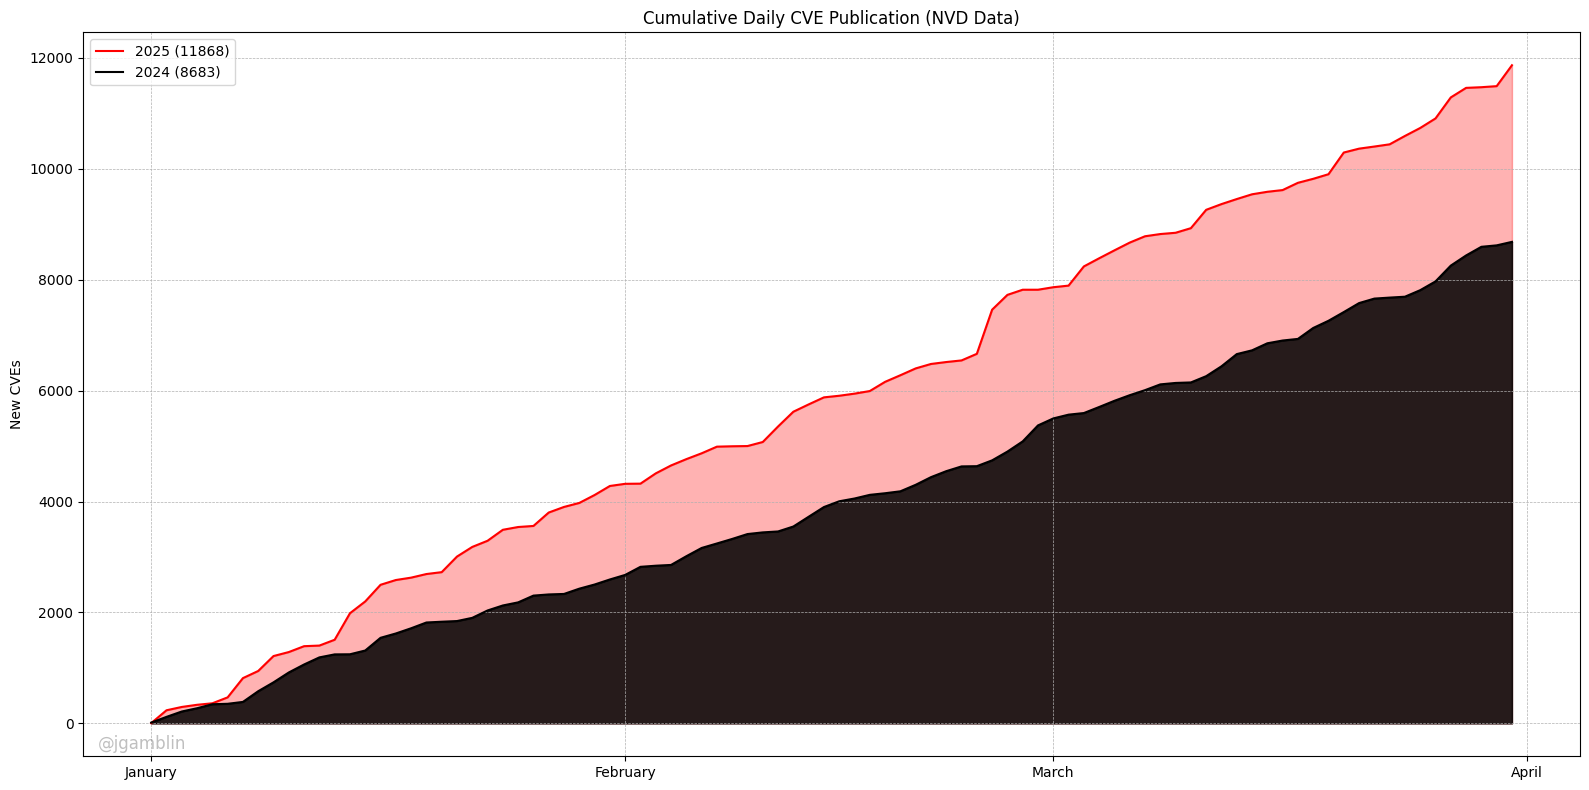

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate the cumulative sum of CVEs
cumulative_cves = Days.cumsum()

# Replace NaN values with 0
cumulative_cves = cumulative_cves.fillna(0)

# Find the last value for 2024 and 2025
last_value_2024 = cumulative_cves['2024'].iloc[-1] if '2024' in cumulative_cves.columns else 0
last_value_2025 = cumulative_cves['2025'].iloc[-1] if '2025' in cumulative_cves.columns else 0

# Plot the cumulative daily CVE publication graph with filled areas
plt.figure(figsize=(16, 8))
plt.plot(cumulative_cves.index, cumulative_cves['2025'], label=f'2025 ({last_value_2025})', color='red')
plt.fill_between(cumulative_cves.index, cumulative_cves['2025'], color='red', alpha=0.3)
plt.plot(cumulative_cves.index, cumulative_cves['2024'], label=f'2024 ({last_value_2024})', color='black')
plt.fill_between(cumulative_cves.index, cumulative_cves['2024'], color='black', alpha=0.85)
plt.title('Cumulative Daily CVE Publication (NVD Data)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylabel("New CVEs")

# Format the x-axis to show only month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Add legend
plt.legend()

# Add watermark
plt.text(0.01, 0.01, '@jgamblin', transform=plt.gca().transAxes, fontsize=12, color='gray', alpha=0.5)

# Adjust layout and save the chart as a PNG file with a descriptive name for publication
plt.tight_layout()
plt.savefig('cumulative_daily_cve_publication_2025.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Function to convert a day to its ordinal representation
def ordinal(n):
    return f"{n}{'th' if 11 <= (n % 100) <= 13 else {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')}"

# Filter data for the year 2025
nvd_2025 = nvd[(nvd['Published'] >= '2025-01-01') & (nvd['Published'] < '2025-04-01')]

# Calculate total number of CVEs in 2025
total_cves_2025 = nvd_2025.shape[0]

# Calculate average CVEs per day in 2025
start_date_2025 = date(2025, 1, 1)
end_date_2025 = nvd_2025['Published'].max().date() + timedelta(days=1)
days_2025 = (end_date_2025 - start_date_2025).days
average_cves_per_day_2025 = total_cves_2025 / days_2025

# Calculate average CVSS score in 2025
average_cvss_score_2025 = nvd_2025['BaseScore'].mean()

# Filter data for the year 2024
nvd_2024 = nvd[(nvd['Published'] >= '2024-01-01') & (nvd['Published'] < '2024-04-01')]

# Calculate total number of CVEs in 2024
total_cves_2024 = nvd_2024.shape[0]

# Calculate YOY growth
yoy_growth = ((total_cves_2025 - total_cves_2024) / total_cves_2024) * 100
yoy_growth_count = total_cves_2025 - total_cves_2024

# Generate the output
output = f"""
2025 CVE Stats Update ({end_date_2025.strftime('%B')} {ordinal(end_date_2025.day)}, {end_date_2025.year})
Total Number of CVEs: {total_cves_2025}
Average CVEs Per Day: {average_cves_per_day_2025:.2f}
Average CVSS Score: {average_cvss_score_2025:.2f}
YOY Growth: {yoy_growth:.2f}% or +{yoy_growth_count} ({total_cves_2024} CVEs in 2024)
"""

print(output)


2025 CVE Stats Update (April 1st, 2025)
Total Number of CVEs: 12010
Average CVEs Per Day: 133.44
Average CVSS Score: 6.55
YOY Growth: 38.32% or +3327 (8683 CVEs in 2024)

